### 0. 함수 import

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.signal import medfilt

In [2]:
font_name = 'Malgun Gothic'
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

### 1-1. df 시계열 데이터 불러오기

In [3]:
# 이 부분은 changable. 데이터를 불러오는 단계
folder_path = './data_temp'  # CSV 파일이 있는 폴더 경로
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dataframes = []
for f in csv_files:
    file_path = os.path.join(folder_path, f)
    try:
        # CSV 파일을 읽어올 때, 8번째와 16번째 열을 float로 지정
        df_temp = pd.read_csv(file_path, dtype={8: float, 16: float})
    except Exception as e:
        print(f"Error reading {file_path}: {e} (assuming error value (over 1,000mg/L DO))")
        continue
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

Error reading ./data_temp\page-01.csv: could not convert string to float: '1,086.7' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-02.csv: could not convert string to float: '1,094.6' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-03.csv: could not convert string to float: '1,024.2' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-04.csv: could not convert string to float: '1,127.6' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-05.csv: could not convert string to float: '1,170.3' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-06.csv: could not convert string to float: '1,029' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-07.csv: could not convert string to float: '1,108.6' (assuming error value (over 1,000mg/L DO))
Error reading ./data_temp\page-08.csv: could not convert string to float: '1,084.4' (assuming error value (over 1

### 1-2. 데이터 기본 구조 및 통계량 확인 (결측치, 이상치 등 개요 파악)

In [4]:
#print(df.info())
#print(df.describe())
#print("결측치 개수:\n", df.isnull().sum())

### 1-3. column 제거 및 시간 통합 (일시로)

In [5]:
# df에서 지역명, 양식장 이름, 시설 이름, 시설 ID를 추출하여 dictionary 생성
facility_id_dict = {}
for index, row in df.iterrows():
    region = row['지역명']
    farm_name = row['양식장 이름']
    facility_name = row['시설 이름']
    facility_id = row['시설 ID']
    facility_names = f"{region} {farm_name} {facility_name.replace(' ', '')}"
    
    if facility_id in facility_id_dict:
        if facility_id_dict[facility_id] != facility_names:
            print(f"시설 ID {facility_id}의 이름이 다릅니다: {facility_id_dict[facility_id]} vs {facility_names}")
    else:
        facility_id_dict[facility_id] = facility_names
# df에서 일자와 시간을 합쳐서 datetime 형식으로 변환 후 일시라는 항목으로 저장
df['일시'] = pd.to_datetime(df['일자'].astype(str) + ' ' + df['시간'].astype(str), format='%Y-%m-%d %H:%M:%S', errors='coerce')
# 미사용 column 제거
df = df.drop(columns=['일자','시간','지역명','양식장 이름','시설 이름','양식장 ID','지역코드','유입수 탁도(fnu)', '유량1(m3/h)','유량2(m3/h)','유량3(m3/h)', 'ORP(mV)', '전압', '전력', 'RPM', '주파수'], errors='ignore')

In [6]:
# 시설 ID, 수온, 일시 세가지 column으로 구성된 df 생성
temper_df = df[['시설 ID', '수온(℃)', '일시']].copy()
temper_df.loc[:, '일시'] = pd.to_datetime(temper_df['일시'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

### 1-4. 리샘플링(결측치 찾기 위해)

In [7]:
resampling_period = '1h' # '1h'도 가능
sampled_df = pd.DataFrame()
for fi in facility_id_dict.keys():
    select_df = temper_df[temper_df['시설 ID'] == fi]
    select_df = select_df.sort_values(by='일시')
    column_name = '수온(℃)'

    # 1. '일시' 컬럼을 인덱스로 설정
    select_df.set_index('일시', inplace=True)
    # 이제 select_df의 인덱스는 '일시' 컬럼의 datetime 값들입니다.
    # 이 인덱스의 이름도 '일시'가 됩니다.

    # 2. 수온 컬럼을 포함하여 리샘플링
    df_resampled = select_df.resample(resampling_period).agg({
        '수온(℃)': 'mean'
    })

    # 3. df_resampled의 시간 인덱스를 다시 '일시' 컬럼으로 만들기 <--- 이 부분이 추가/수정되어야 합니다.
    df_resampled.reset_index(inplace=True)

    df_resampled['시설 ID'] = fi
    
    sampled_df = pd.concat([sampled_df, df_resampled], ignore_index=True)

### 1-4-2. 임계값 데이터 제거

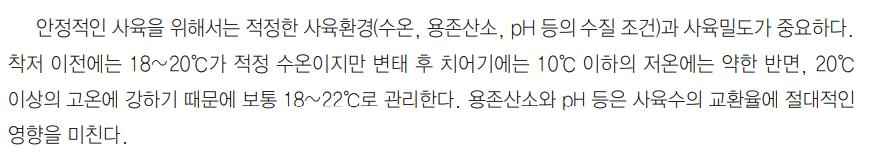

In [8]:
temp_min = 0 #임계없음
#temp_min = 17 #적정 수온 18~22도를 기준. 최저수온 18 -1도
#temp_min = 10 #(이 값은 임계값)
temp_max = 100 #임계없음
#temp_max = 23 #적정 수온 18~22도를 기준. 최고수온 22 +1도 
#temp_max = 27 #(이 값은 임계값)

condition = (sampled_df['수온(℃)'] <= temp_min) | (sampled_df['수온(℃)'] >= temp_max)

# 2. .loc를 사용하여 조건에 맞는 행의 '수온(℃)' 컬럼 값을 np.nan으로 변경
sampled_df.loc[condition, '수온(℃)'] = np.nan

### 1-4-3. SPIKE 제거

In [9]:
for fi in facility_id_dict.keys():
    final_extracted_list = sampled_df[sampled_df['시설 ID'] == fi][['수온(℃)', '일시']].values.tolist()
    # 1. y값과 x값(시간) 추출
    y_values_orig = np.array([item[0] for item in final_extracted_list], dtype=float)
    x_values_orig_dt = [item[1] for item in final_extracted_list] # datetime 객체 리스트

    if len(y_values_orig) < 2:
        print("Δy를 계산하려면 최소 2개의 y값이 필요합니다.")
        # 이 경우 아래 로직 실행 안 함
    else:
        delta_y = np.diff(y_values_orig)
        x_values_for_delta_y = x_values_orig_dt[1:] # Δy에 대한 x축 값

        lower_threshold, upper_threshold = -np.inf, np.inf # 기본값
        anomalous_dy_indices = np.array([]) # 기본값

        if len(delta_y) == 0:
            print("Δy 배열이 비어있어 임계값을 계산할 수 없습니다.")
        else:
            delta_y_no_nan = delta_y[~np.isnan(delta_y)]
            if len(delta_y_no_nan) < 2:
                print("Δy 배열에서 NaN을 제외한 유효 데이터가 부족하여 IQR 임계값을 계산할 수 없습니다.")
            else:
                Q1 = np.percentile(delta_y_no_nan, 25)
                Q3 = np.percentile(delta_y_no_nan, 75)
                IQR = Q3 - Q1
                iqr_multiplier = 1.5 # 민감도 조절 변수
                lower_threshold = Q1 - iqr_multiplier * IQR
                upper_threshold = Q3 + iqr_multiplier * IQR
                
                print("--- 자동 임계값 계산 결과 (IQR 방식) ---")
                print(f"  (NaN이 아닌 Δy 값 {len(delta_y_no_nan)}개로 계산)")
                print(f"  Δy - Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
                print(f"  하한 임계값: {lower_threshold:.3f}, 상한 임계값: {upper_threshold:.3f}")

                anomalous_dy_indices = np.where((delta_y < lower_threshold) | (delta_y > upper_threshold))[0]
                print(f"\n자동 임계값을 벗어난 Δy 개수: {len(anomalous_dy_indices)}")

        # 스파이크로 식별된 원본 y_values_orig의 인덱스
        identified_y_spike_indices = []
        if len(delta_y) > 1: # Δy가 최소 2개는 있어야 연속된 두 개의 Δy를 비교 가능
            for i in range(len(delta_y) - 1):
                if np.isnan(delta_y[i]) or np.isnan(delta_y[i+1]): # NaN 값 건너뛰기
                    continue
                current_dy_is_outlier = (delta_y[i] < lower_threshold) or (delta_y[i] > upper_threshold)
                next_dy_is_outlier = (delta_y[i+1] < lower_threshold) or (delta_y[i+1] > upper_threshold)
                if current_dy_is_outlier and next_dy_is_outlier and (np.sign(delta_y[i]) * np.sign(delta_y[i+1]) == -1):
                    spike_candidate_index = i + 1
                    identified_y_spike_indices.append(spike_candidate_index)
        identified_y_spike_indices = sorted(list(set(identified_y_spike_indices)))
        print(f"\n스파이크로 식별되어 NaN 처리될 y_values_orig의 인덱스: {identified_y_spike_indices}")
        

        # 원본 y 데이터에서 이상치 처리 (NaN으로 변경)
        y_values_cleaned = np.copy(y_values_orig)
        for idx in identified_y_spike_indices:
            if 0 <= idx < len(y_values_cleaned):
                y_values_cleaned[idx] = np.nan
        
        condition = (sampled_df['시설 ID'] == fi)
        sampled_df.loc[condition, '수온(℃)'] = y_values_cleaned

--- 자동 임계값 계산 결과 (IQR 방식) ---
  (NaN이 아닌 Δy 값 8096개로 계산)
  Δy - Q1: -0.033, Q3: 0.000, IQR: 0.033
  하한 임계값: -0.083, 상한 임계값: 0.050

자동 임계값을 벗어난 Δy 개수: 3275

스파이크로 식별되어 NaN 처리될 y_values_orig의 인덱스: [19, 84, 100, 154, 451, 452, 476, 505, 527, 909, 976, 1006, 1033, 1222, 1291, 1292, 1506, 1605, 1648, 1746, 1747, 2181, 2439, 2440, 2589, 2636, 2638, 2641, 2642, 2651, 2794, 2823, 2824, 2952, 2967, 2976, 3071, 3159, 3164, 3181, 3289, 3290, 3308, 3375, 3384, 3400, 3485, 3486, 3519, 3523, 3589, 3590, 3687, 3711, 3976, 3996, 4097, 4287, 4288, 4289, 4313, 4489, 4490, 4502, 4704, 4888, 4893, 4937, 5107, 5108, 5141, 5376, 5377, 5426, 5429, 5437, 5493, 5594, 5595, 5603, 5628, 7704, 7824, 7850, 7885, 7941, 7942, 7968, 7986, 8064, 8136, 8173, 8222, 8255, 8274, 8353, 8477, 8539, 8552, 8655, 8689, 8690, 8703, 8760, 8808, 8838, 9021, 9023, 9035, 9038, 9052, 9061, 9084, 9085, 9105, 9131, 9135, 9136, 9339, 9358, 9379, 9386, 9439, 9440, 9470, 9513, 9518, 9532, 9537, 9542, 9551, 9558, 9603, 9620, 9624, 9640, 9

### 1-5-1. 중앙값 필터링

In [10]:
# --- 중앙값 필터 적용 ---
# kernel_size는 필터 윈도우의 크기를 의미하며, 반드시 홀수여야 합니다.
# 이 값은 데이터의 특성과 제거하려는 스파이크의 폭에 따라 조정해야 합니다.
# 작은 값(예: 3, 5)은 짧은 스파이크를 제거하고, 큰 값은 더 많이 평탄화합니다.
kernel_s = 5 # 예시로 5를 사용 (데이터 포인트 5개 기준 중앙값)

for fi in facility_id_dict.keys():
    target_df = sampled_df[sampled_df['시설 ID'] == fi].copy()
    original_y_values = target_df['수온(℃)'].values
    filtered_y_values = medfilt(original_y_values, kernel_size=kernel_s)
    sampled_df.loc[sampled_df['시설 ID'] == fi, 'temp_median(℃)'] = filtered_y_values
    """
    # --- 결과 시각화 ---
    plt.figure(figsize=(15, 7))

    # 원본 데이터 플롯
    plt.plot(target_df['일시'], target_df['수온(℃)'], label='original temp(y)', marker='.', linestyle='-', color='lightcoral', alpha=0.7)

    # 중앙값 필터 적용된 데이터 플롯
    plt.plot(target_df['일시'], target_df['temp_median(℃)'], label=f'median filtered temp(y) (kernel_size={kernel_s})', marker='.', linestyle='-', color='royalblue')

    plt.title(f'facil ID: {fi} - original vs median filtered', fontsize=16) # fi 변수 사용 시
    # plt.title('원본 수온 vs 중앙값 필터 적용 수온', fontsize=16) # fi 변수 미사용 시
    plt.xlabel('date', fontsize=12)
    plt.ylabel('water temperature (℃)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # x축 시간 포맷 설정 (데이터가 많을 경우 유용)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate() # x축 레이블이 겹치지 않도록 자동 조정

    plt.tight_layout()
    plt.show()
    """

### 1-5-2. 지수 평균 이동 적용

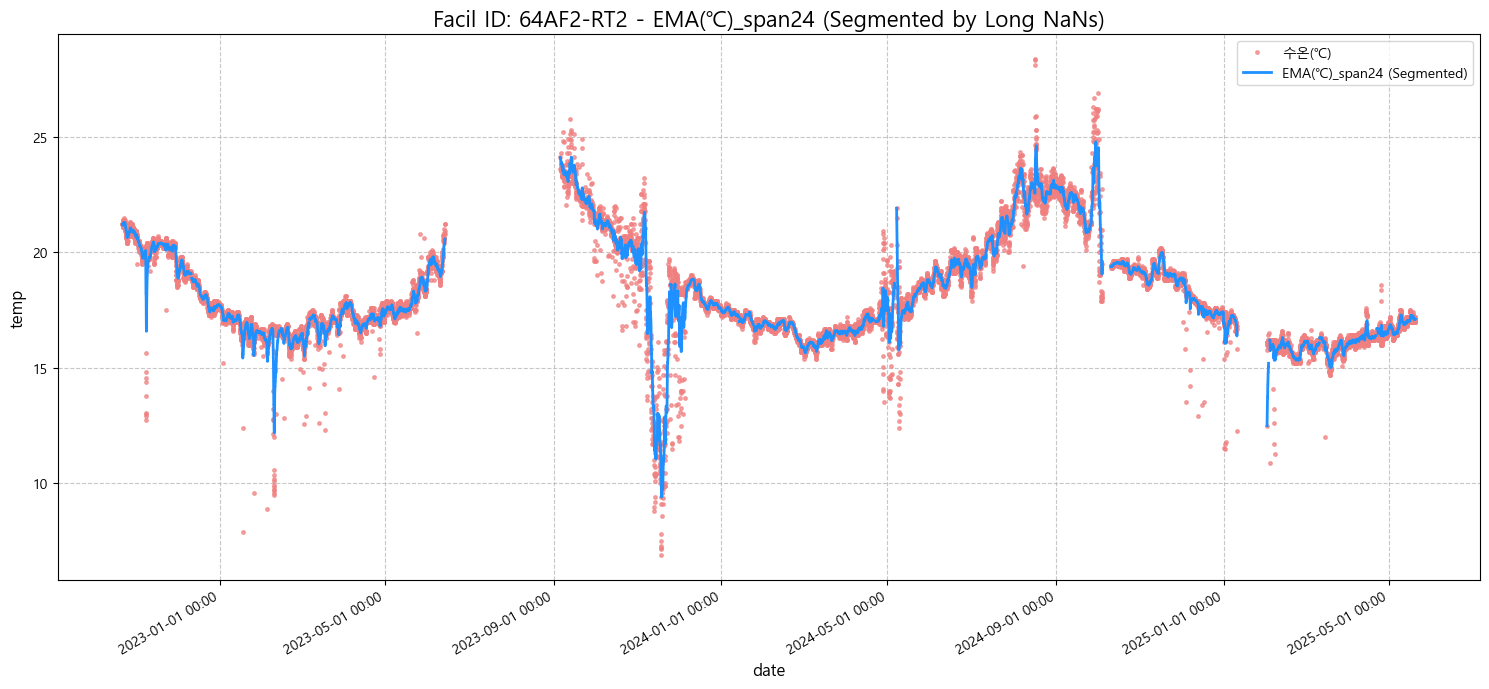

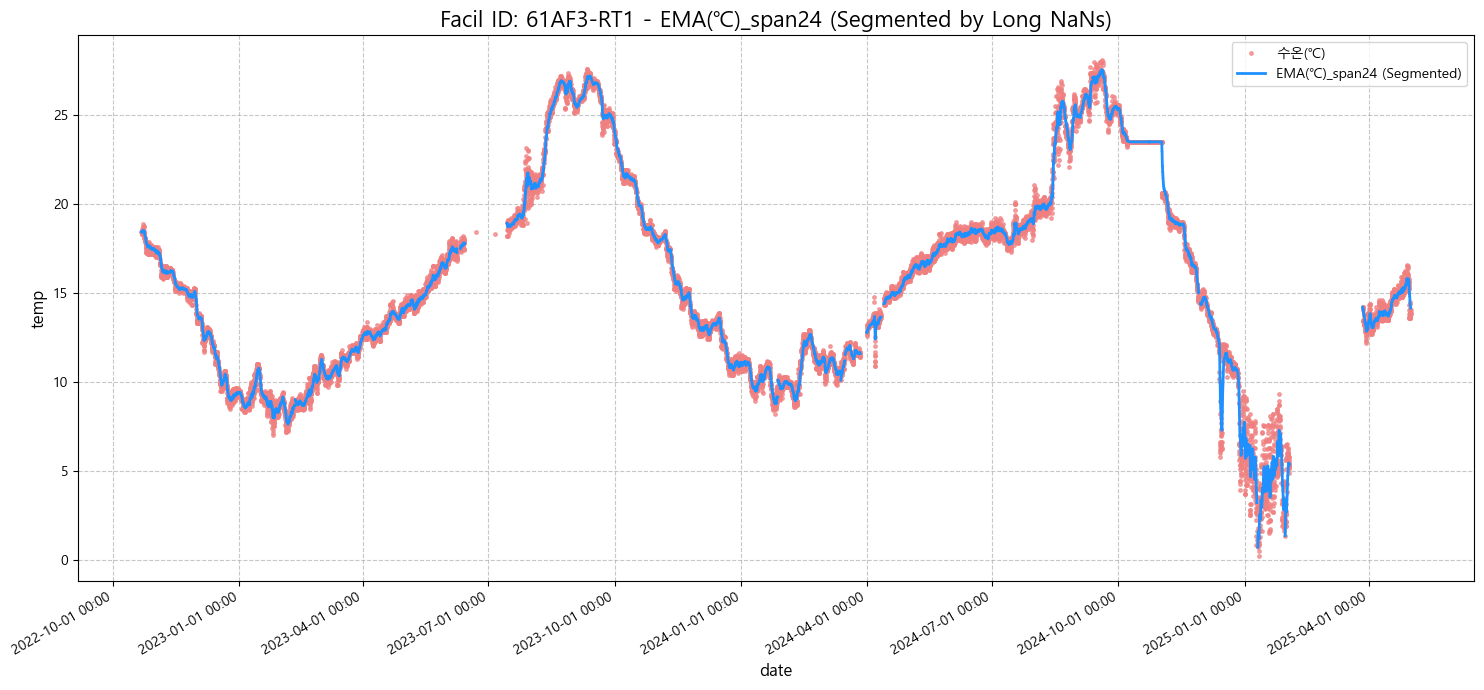

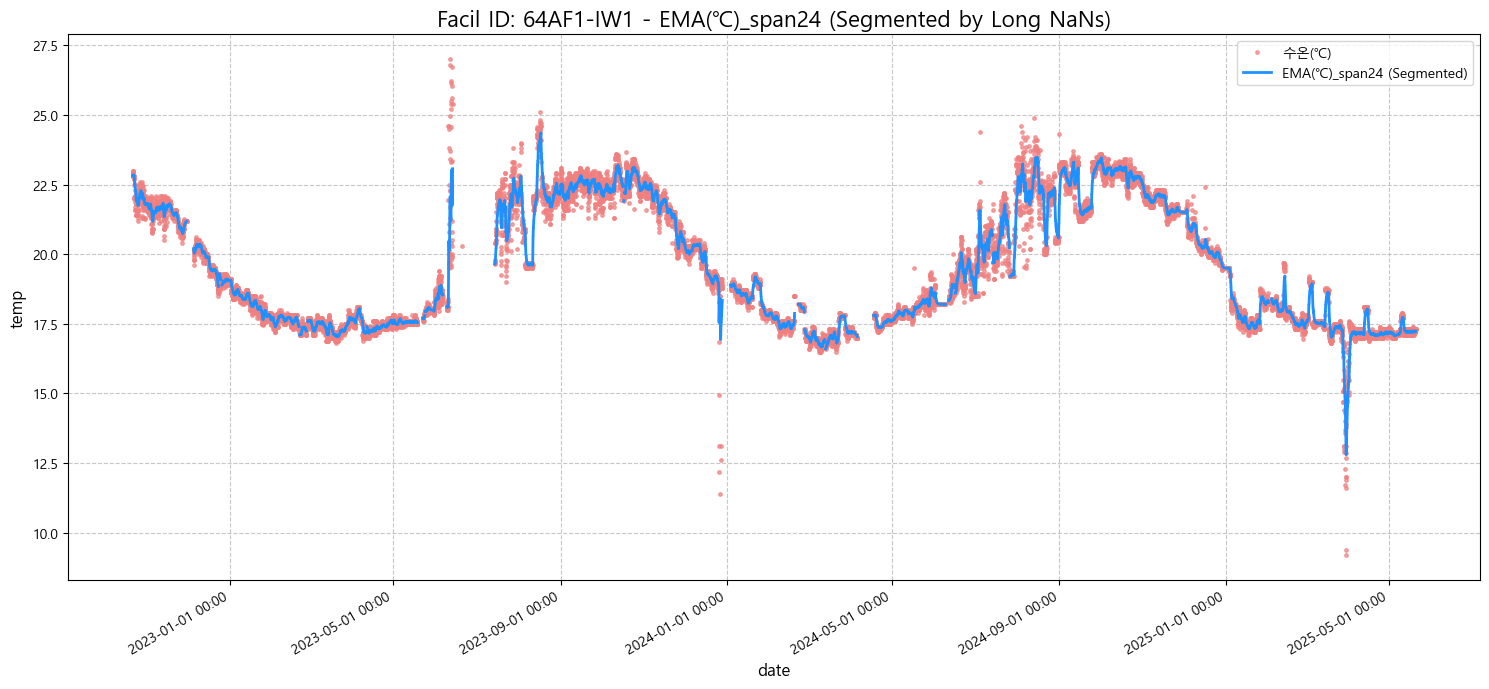

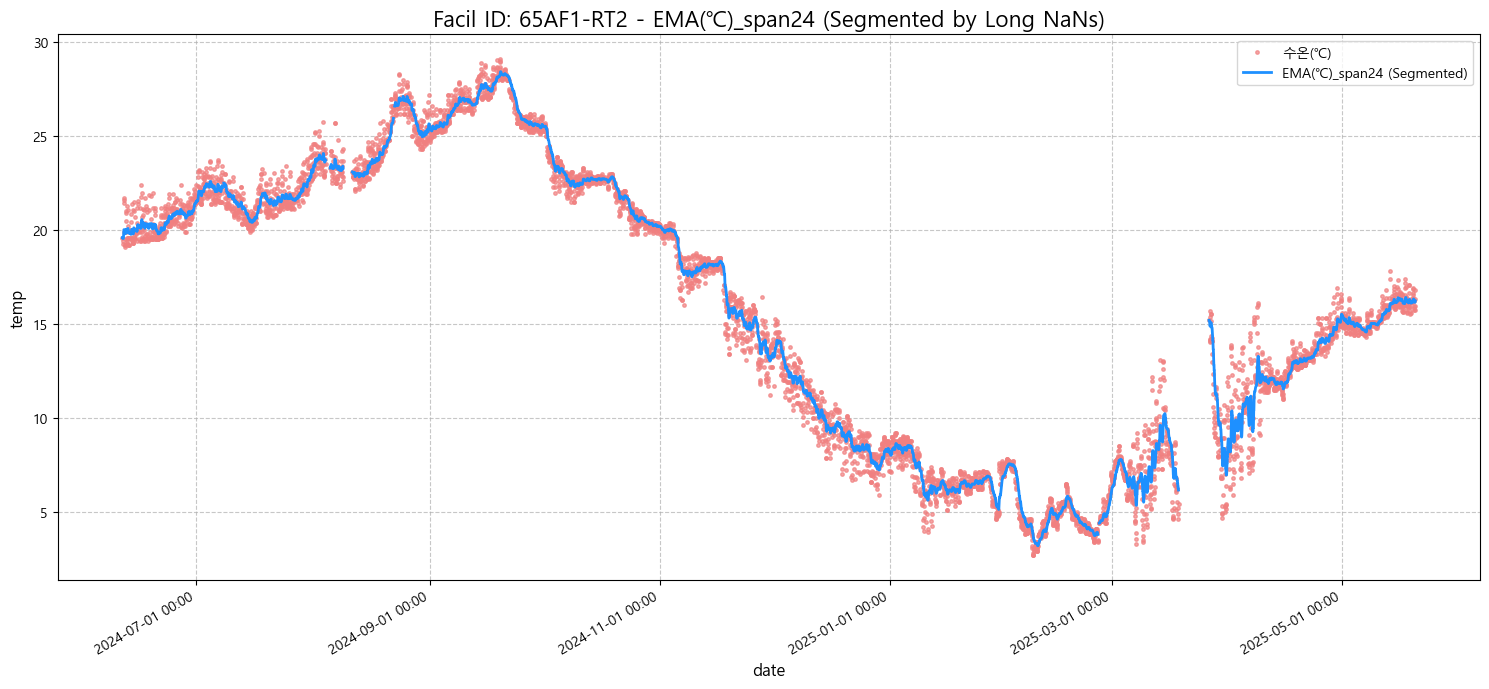

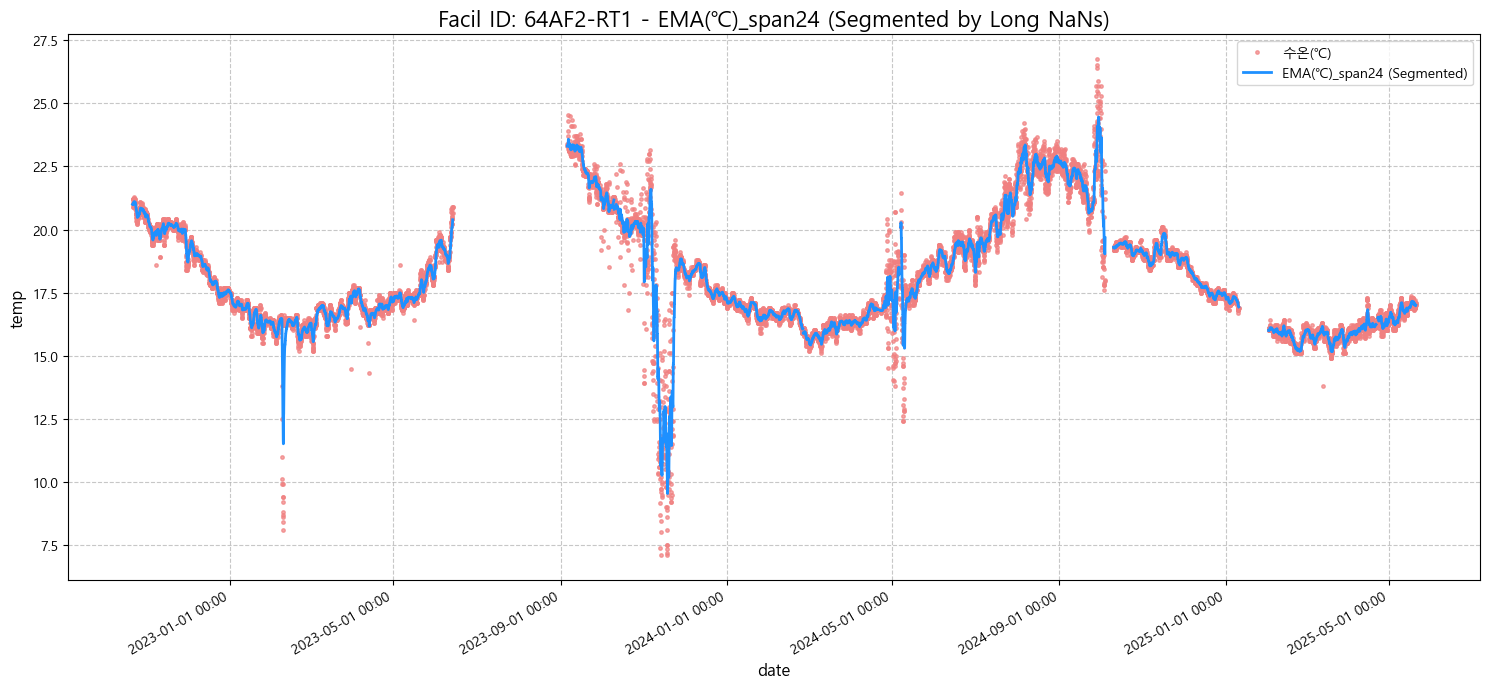

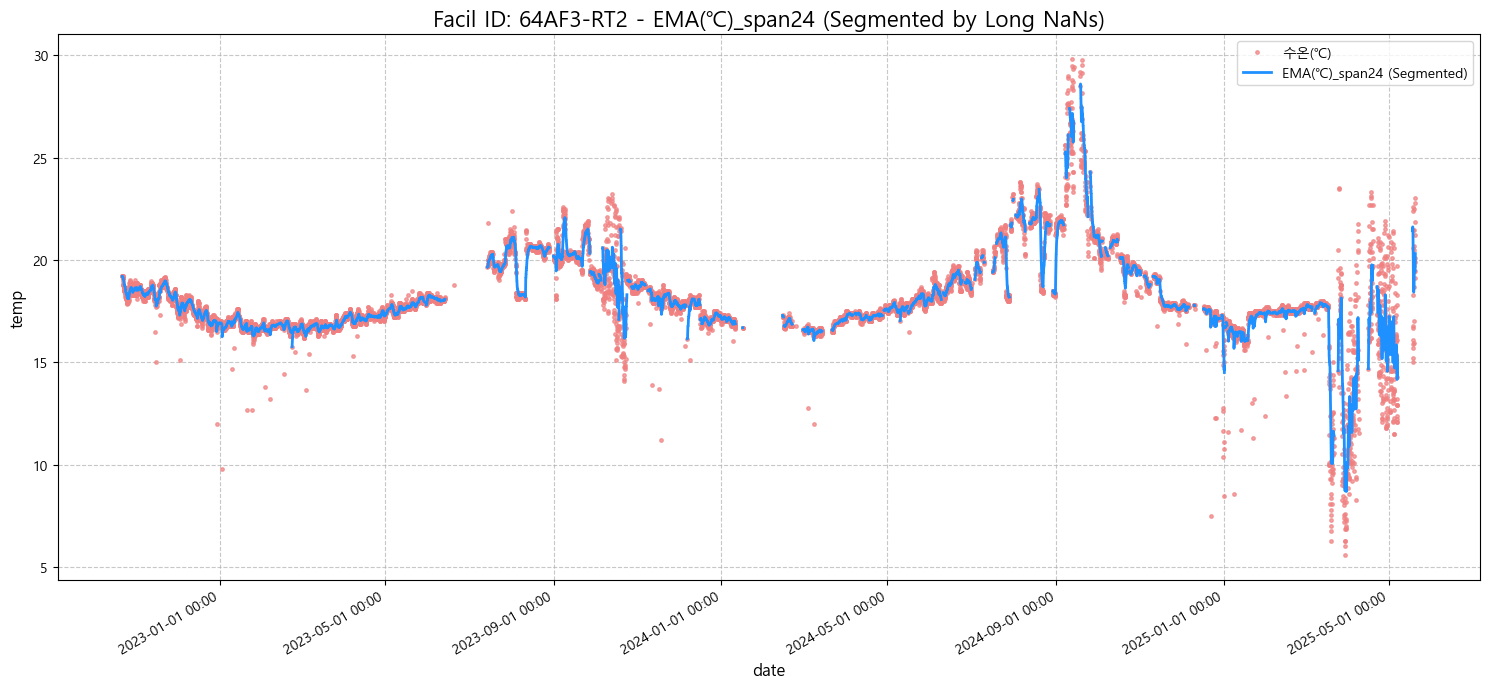

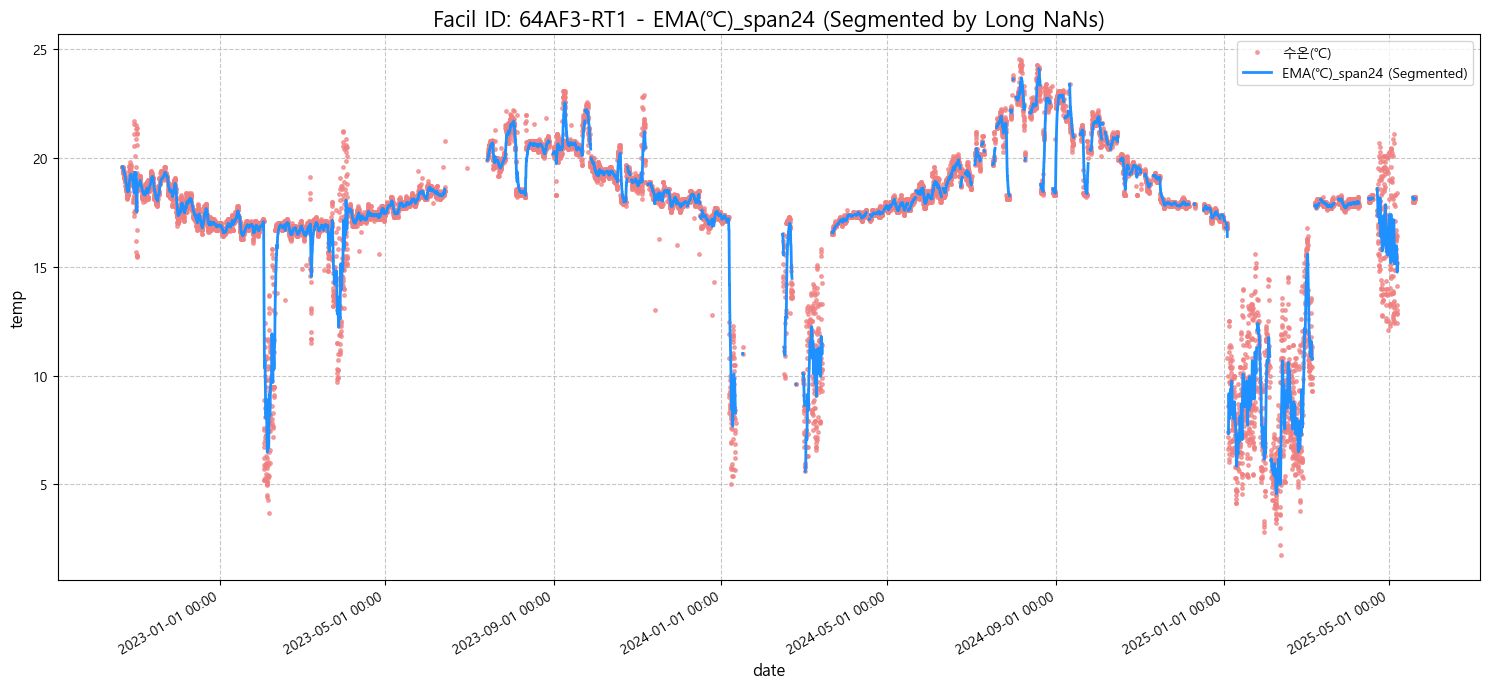

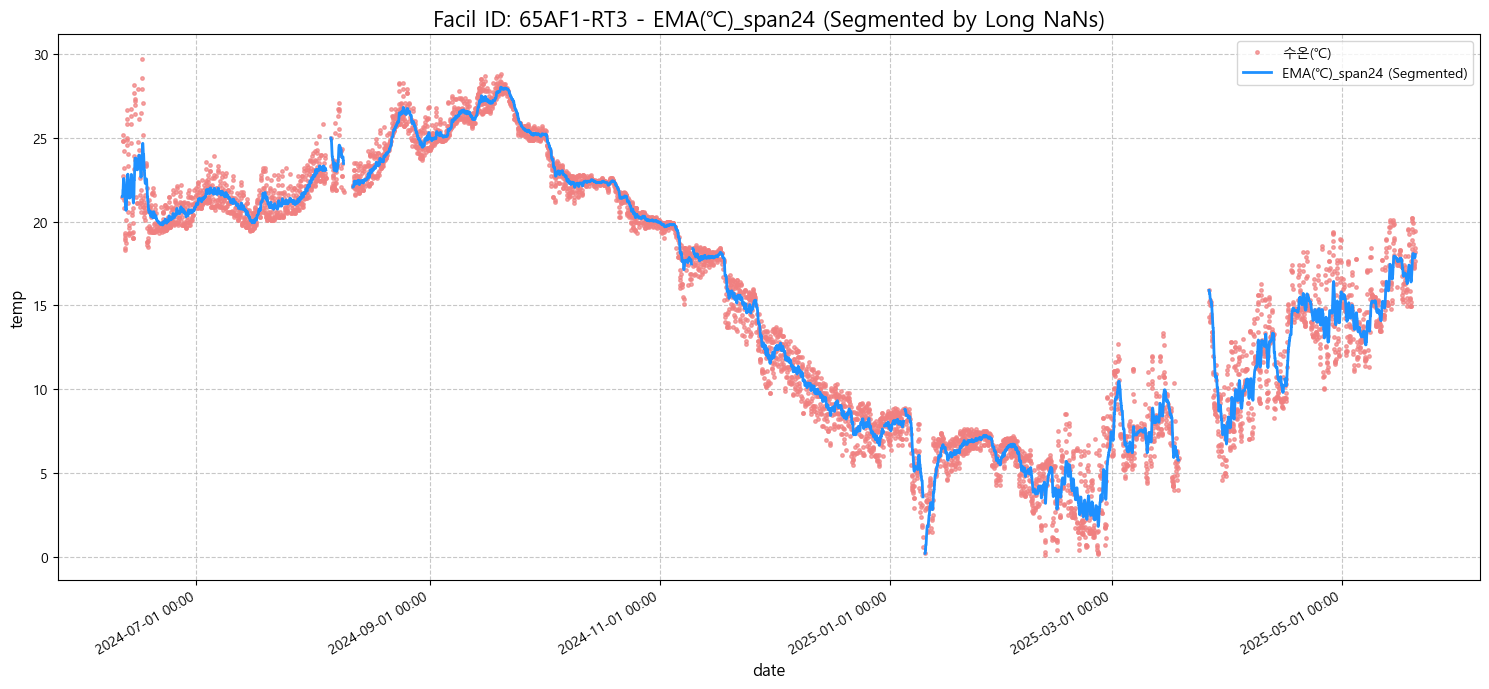

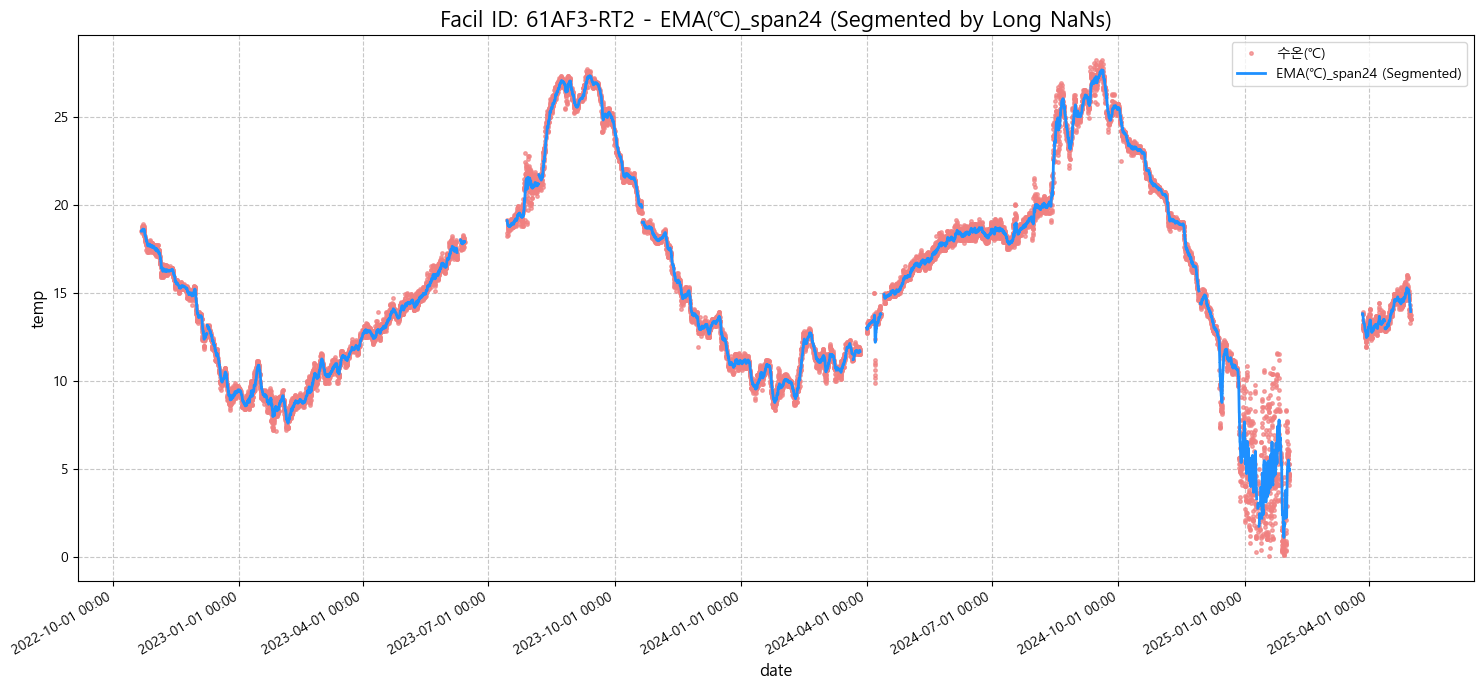

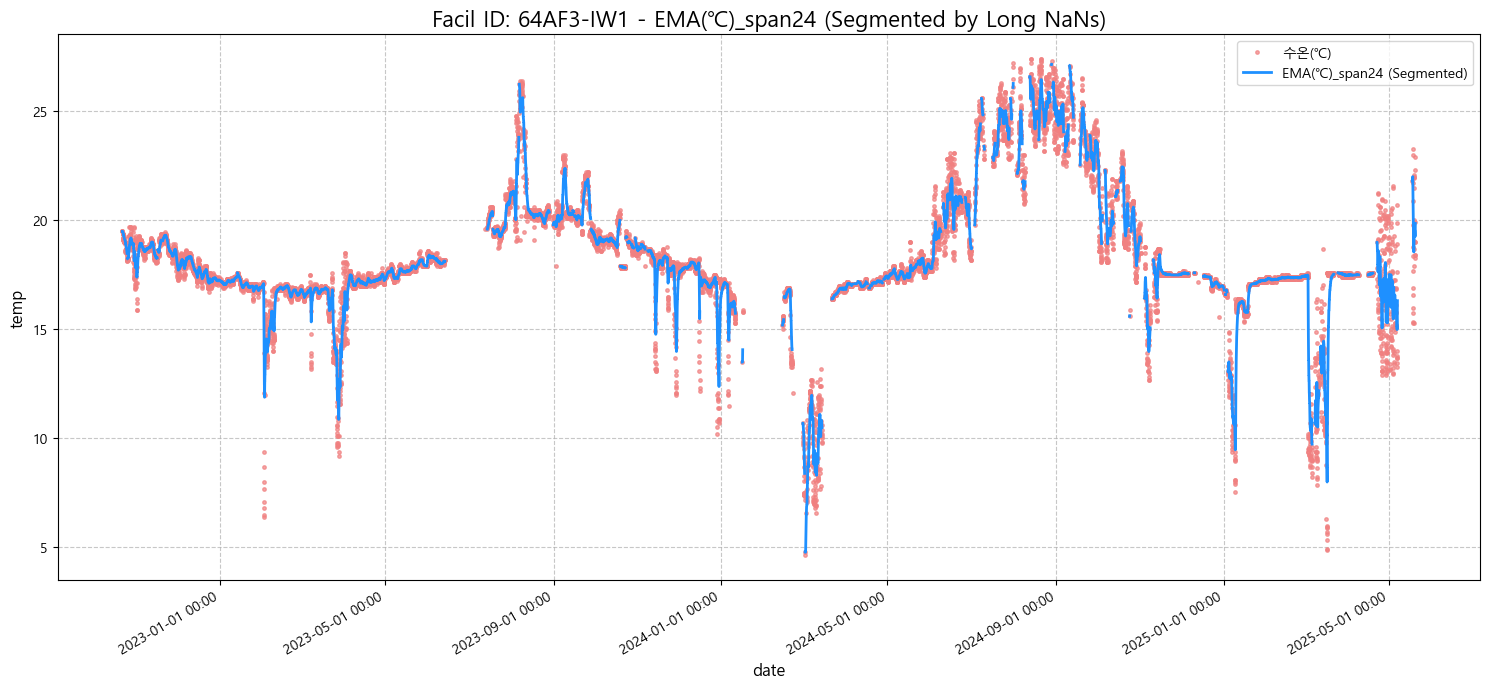

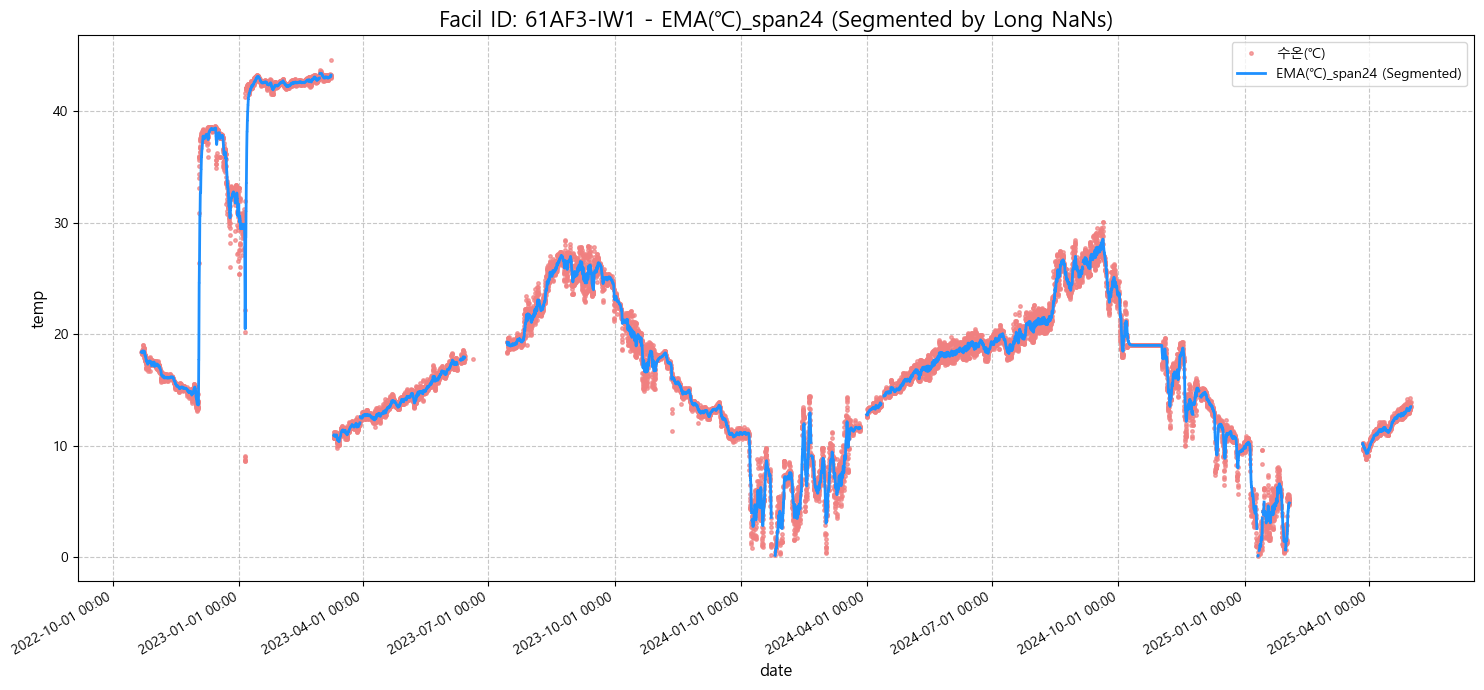

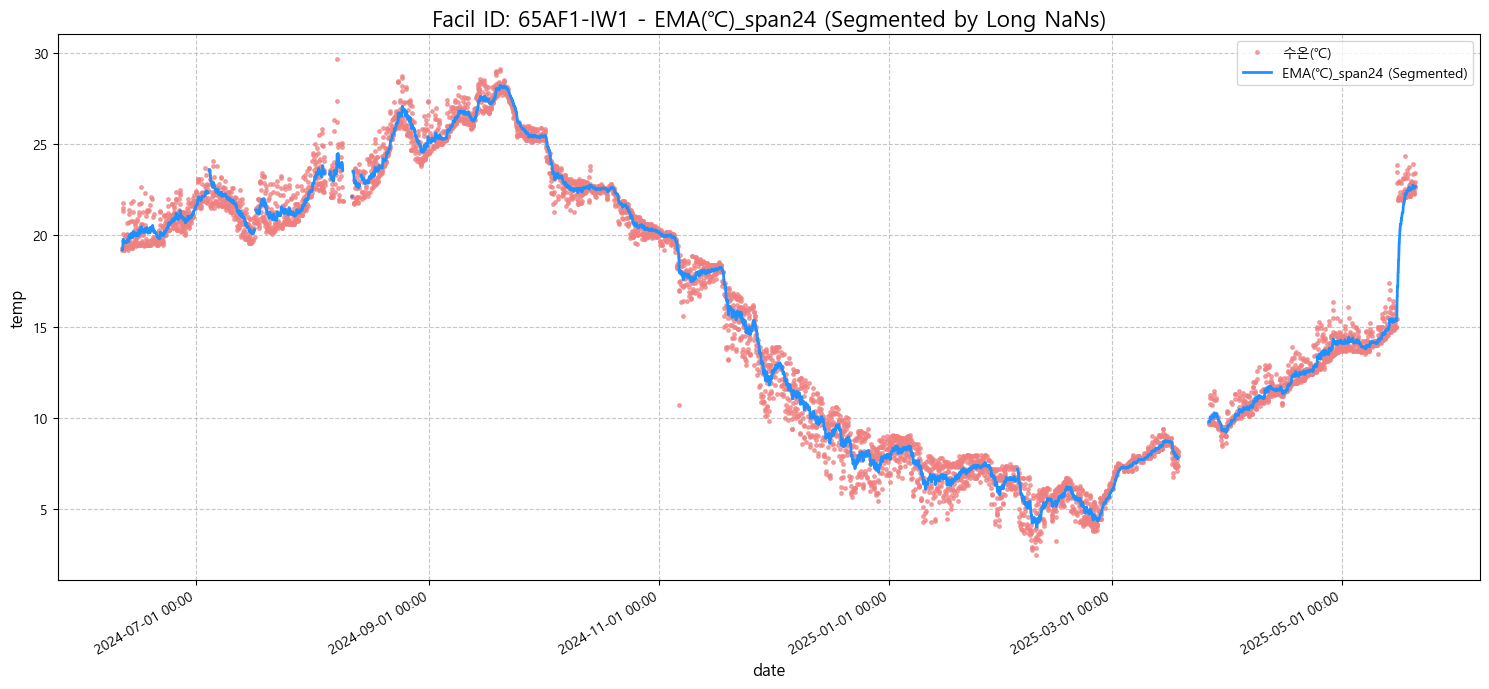

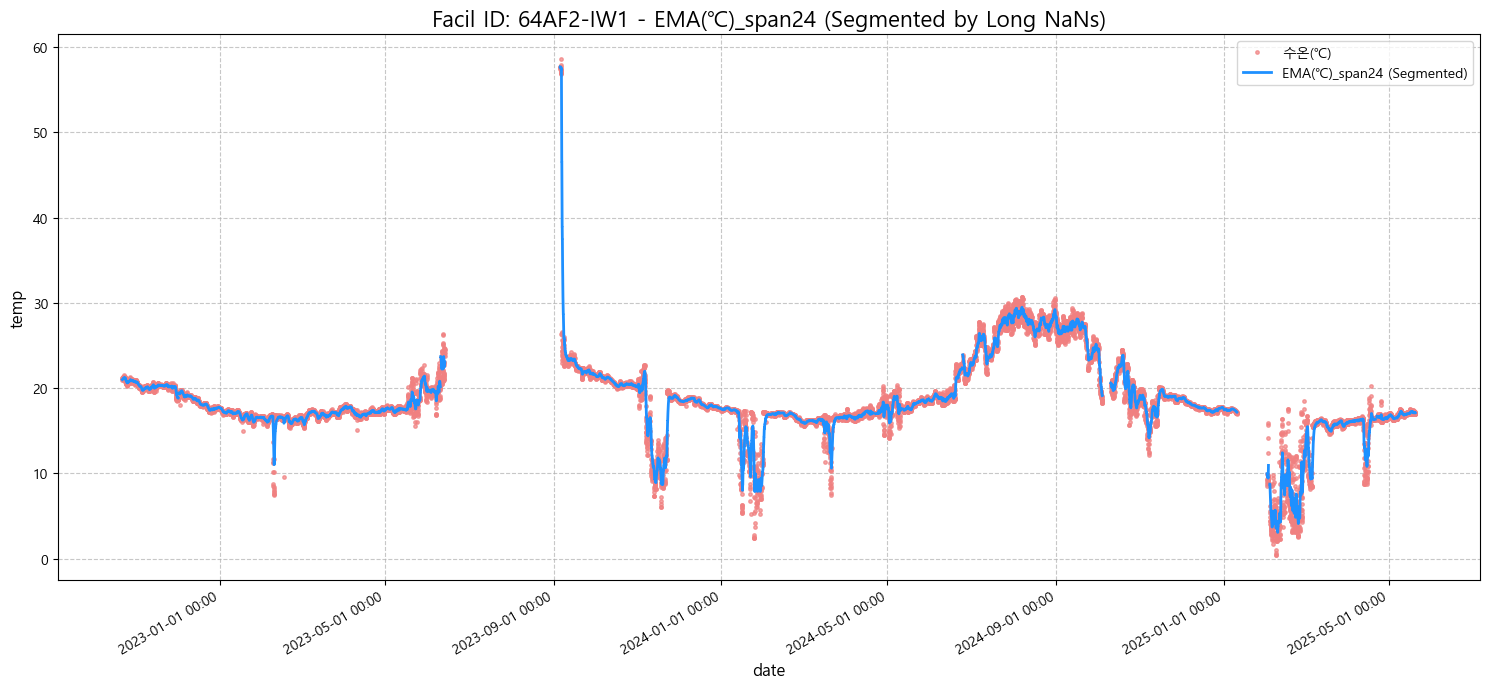

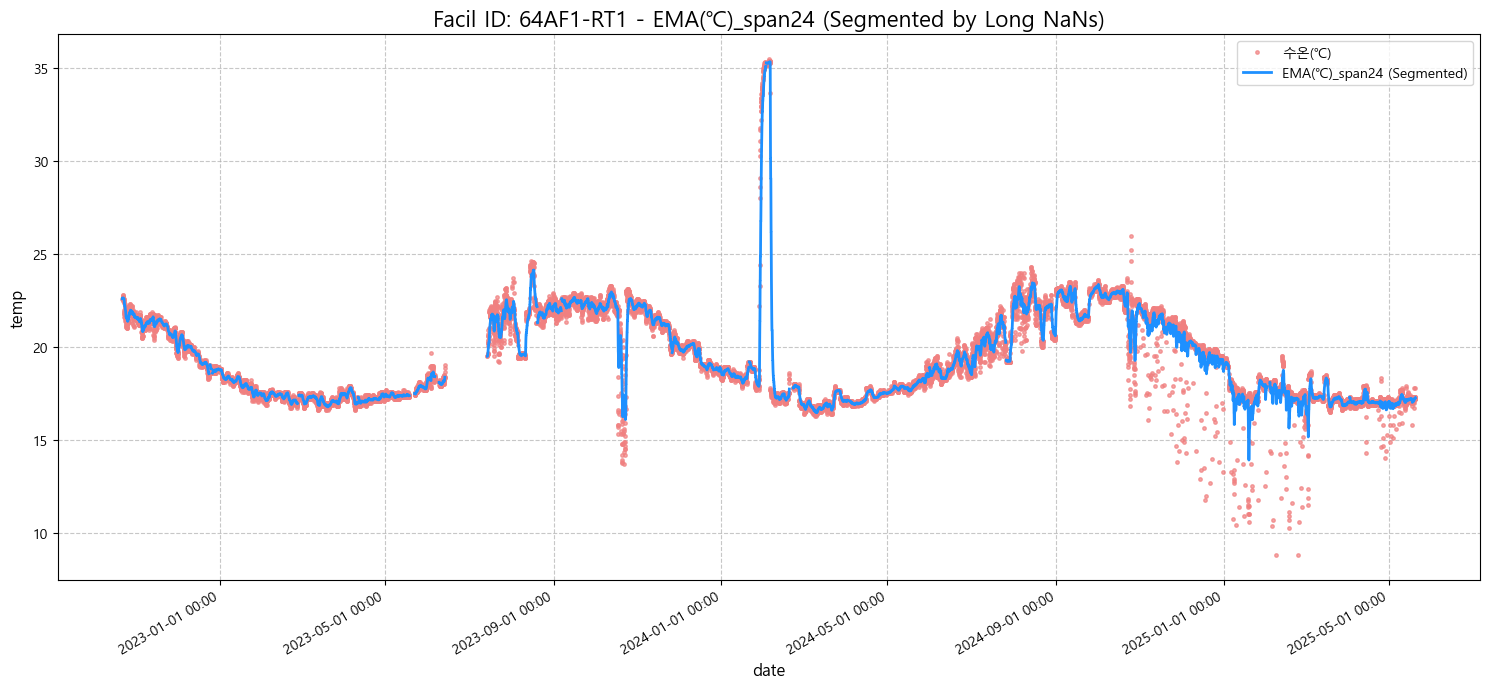

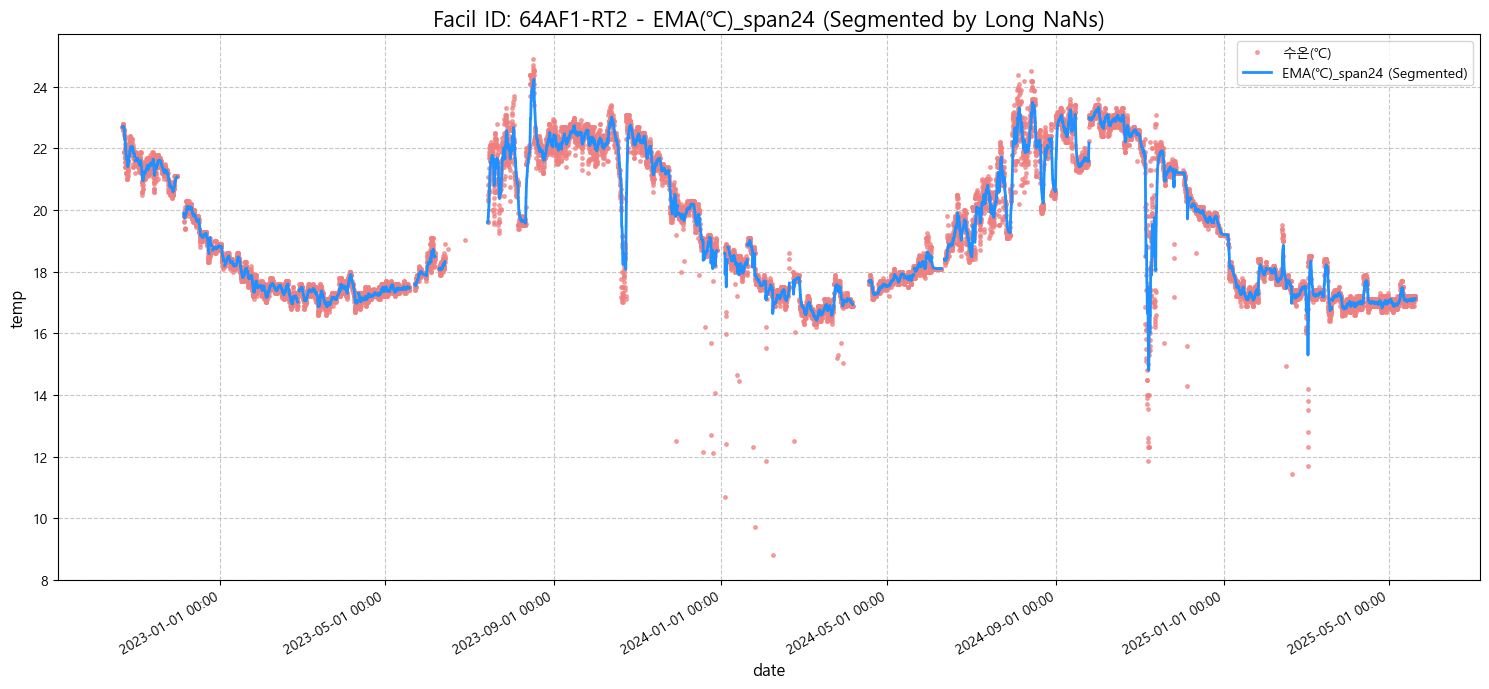

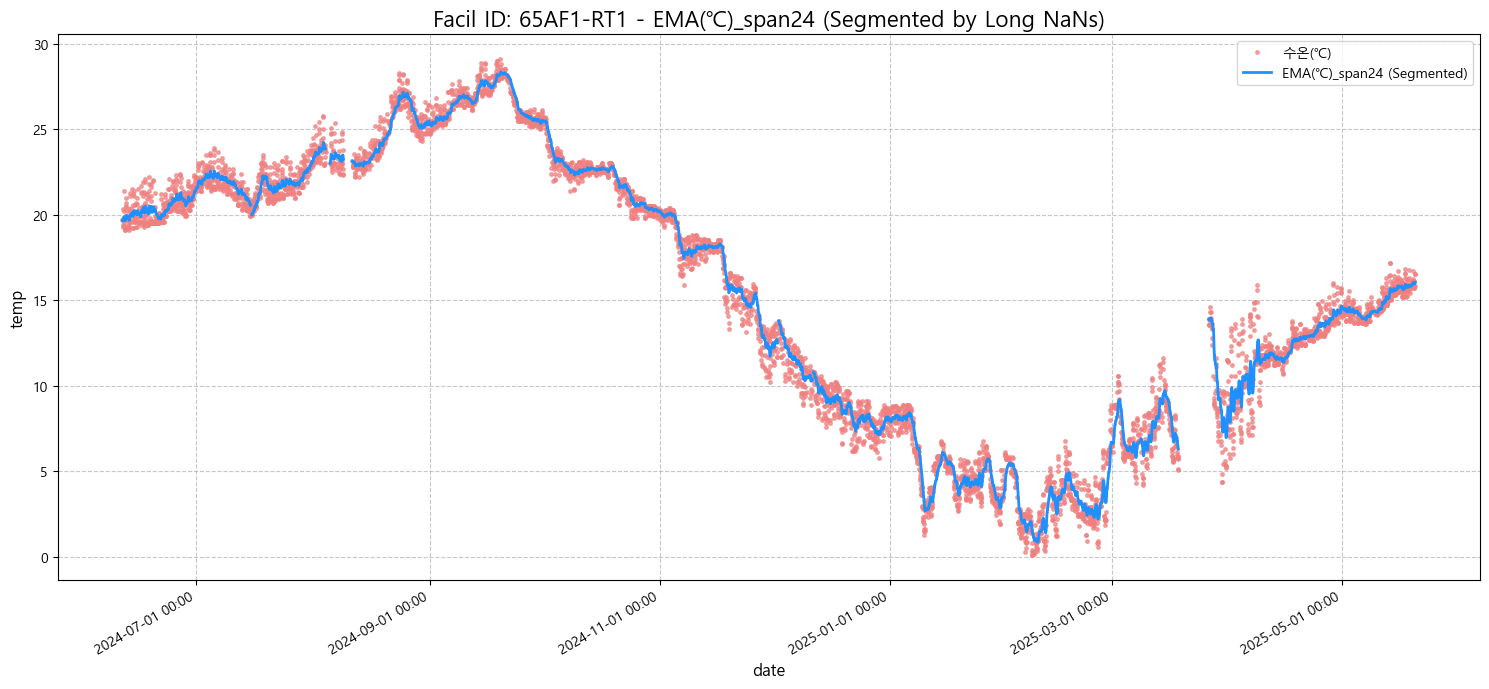

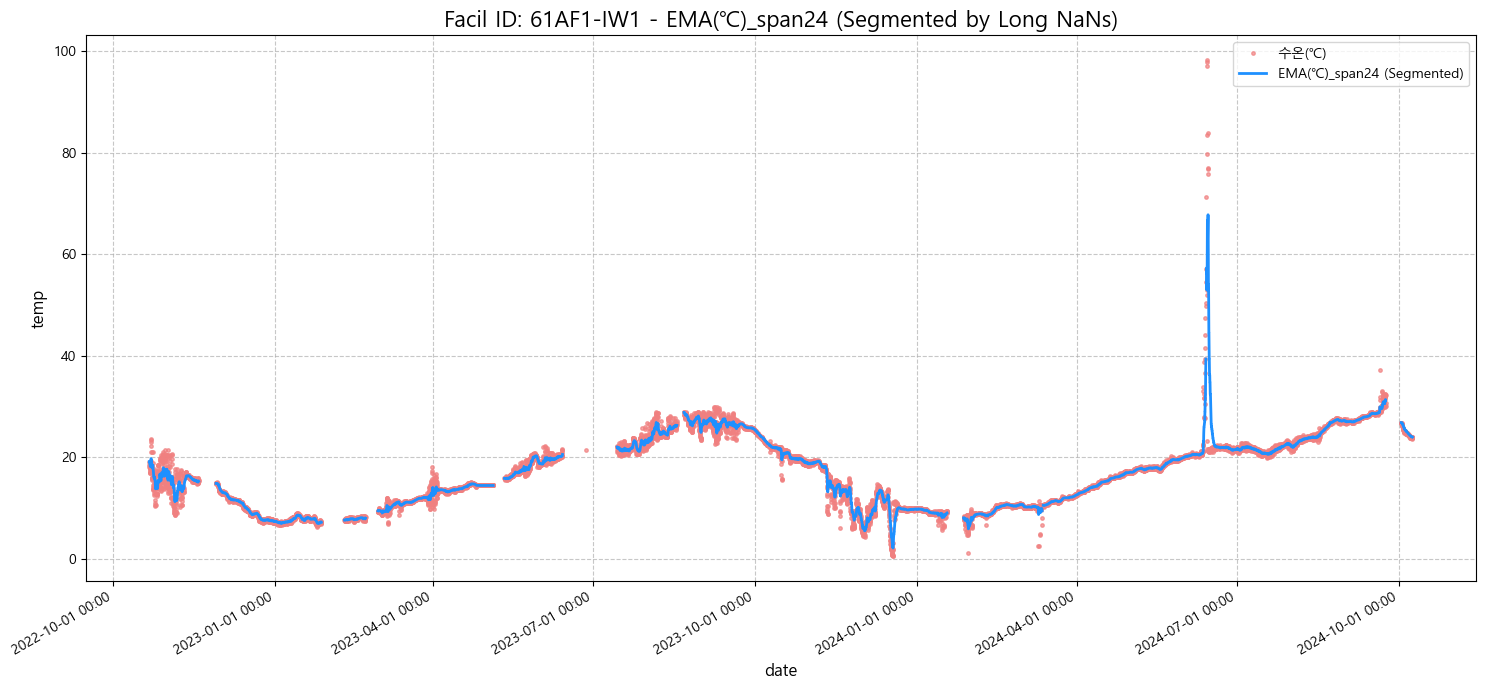

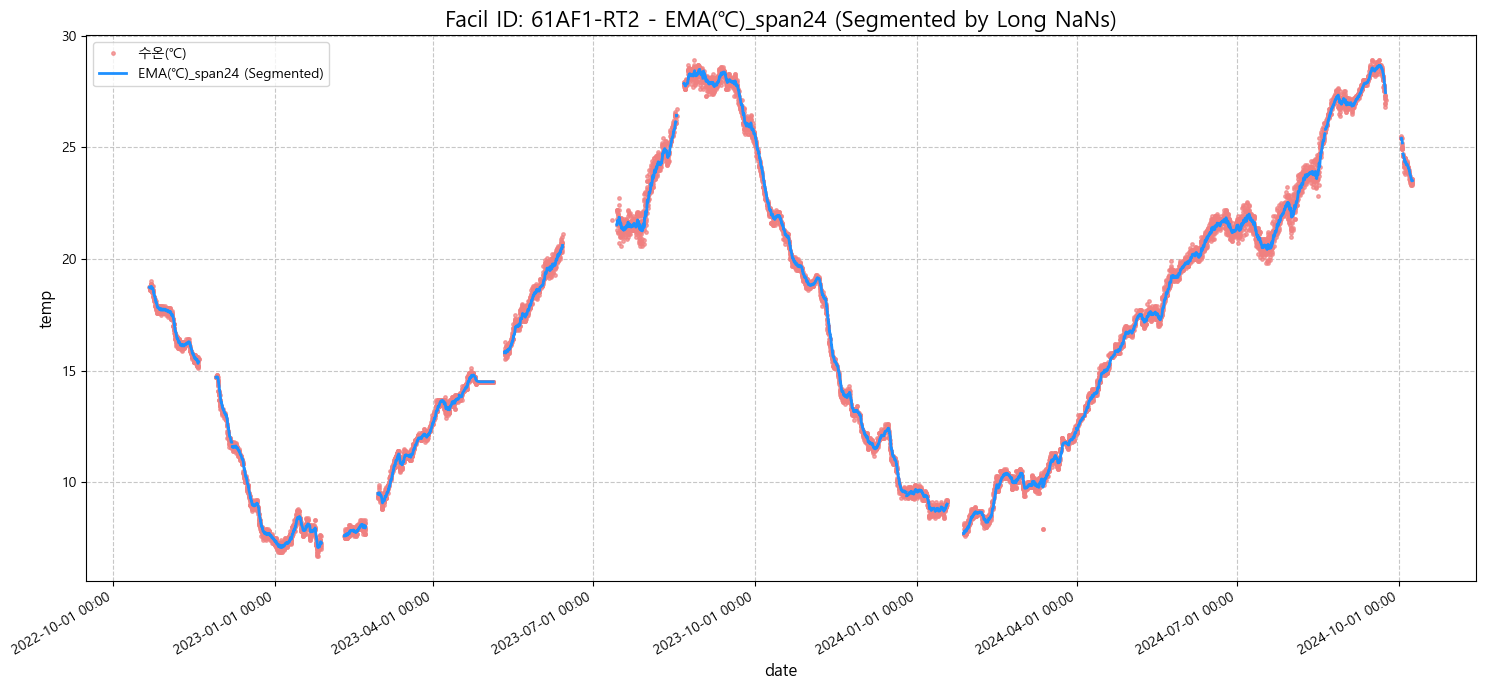

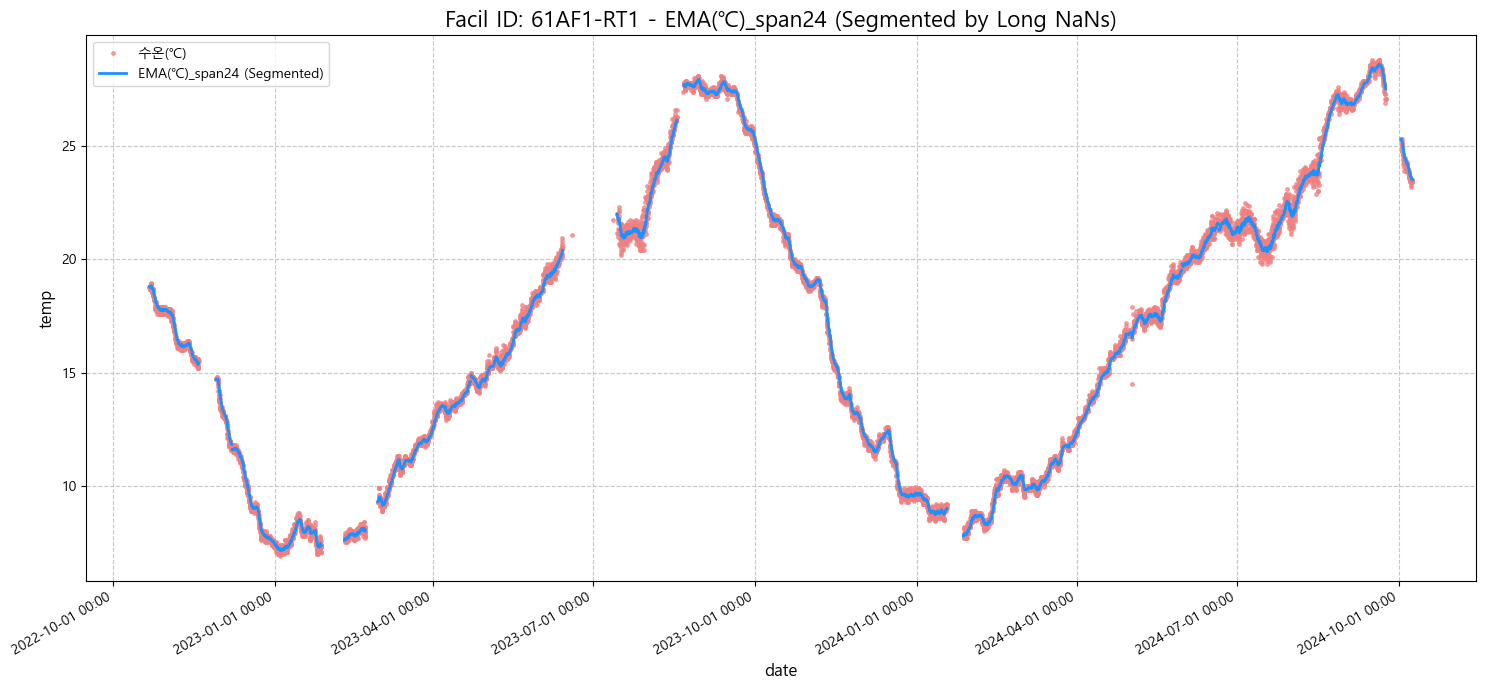

In [11]:

median_filtered_column_name = f'수온(℃)'
ema_span = 24 # 예시 span 값, 데이터에 맞게 조정 필요
nan_stretch_threshold = 7

for fi in facility_id_dict.keys():
    target_df = sampled_df[sampled_df['시설 ID'] == fi].copy()
    if not pd.api.types.is_datetime64_any_dtype(target_df['일시']):
        target_df['일시'] = pd.to_datetime(target_df['일시'])
    target_df = target_df.sort_values(by='일시').reset_index(drop=True)

    if median_filtered_column_name not in target_df.columns:
        print(f"'{median_filtered_column_name}' 컬럼이 target_df '{fi}'에 없습니다. 컬럼명을 확인해주세요.")
        # continue # 원래 루프에서는 다음 fi로 넘어감

    else:
        # --- 1. 긴 NaN 구간을 기준으로 데이터 분할 준비 ---
        target_df['is_na'] = target_df[median_filtered_column_name].isna()
        # is_na가 True/False로 바뀌는 지점을 기준으로 블록 ID 생성
        target_df['na_block_id'] = (target_df['is_na'] != target_df['is_na'].shift()).cumsum()
        # 각 블록(연속된 NaN 또는 연속된 non-NaN)의 크기 계산
        target_df['na_block_size'] = target_df.groupby('na_block_id')['is_na'].transform('size')
        
        # '긴 NaN 구간'에 해당하는지 여부 표시 (is_na가 True이고, 해당 NaN 블록 크기가 임계값 이상)
        target_df['is_long_nan_divider'] = target_df['is_na'] & (target_df['na_block_size'] >= nan_stretch_threshold)

        # '긴 NaN 구간'을 기준으로 데이터 세그먼트 그룹 ID 생성
        # is_long_nan_divider 상태가 바뀌는 지점을 기준으로 그룹 ID 부여
        target_df['segment_group'] = (target_df['is_long_nan_divider'] != target_df['is_long_nan_divider'].shift()).cumsum()

        ema_column_name = f'EMA(℃)_span{ema_span}'
        target_df[ema_column_name] = np.nan # EMA 결과를 저장할 컬럼 초기화 (NaN으로)

        # --- 2. 각 데이터 세그먼트별 EMA 계산 ---
        for G_idx, group_df in target_df.groupby('segment_group'):
            if group_df['is_long_nan_divider'].all():
                # 이 그룹 전체가 '긴 NaN 구간'인 경우 EMA 계산하지 않음 (컬럼은 이미 NaN으로 초기화됨)
                continue
            else:
                # 이 그룹은 실제 데이터 세그먼트임 (짧은 NaN을 포함할 수 있음)
                data_series_for_ema = group_df[median_filtered_column_name]
                
                # EMA 계산을 위한 최소 유효 데이터 포인트 수 확인 (min_periods=1 이므로 1개 이상)
                if data_series_for_ema.notna().sum() >= 1: 
                    segment_ema_values = data_series_for_ema.ewm(span=ema_span, adjust=False, min_periods=1, ignore_na=False).mean()
                    # 계산된 EMA 값을 원래 DataFrame의 해당 위치에 할당
                    target_df.loc[segment_ema_values.index, ema_column_name] = segment_ema_values
                    # # 디버깅: 각 세그먼트의 EMA 값 확인
                    # print(f"EMA for segment group {G_idx} (indices {group_df.index.min()}-{group_df.index.max()}) calculated.")
                    # print(segment_ema_values.head())


        # --- 3. 결과 시각화 ---
        # target_df[ema_column_name]에는 이제 구간별 EMA가 계산되어 있고,
        # '긴 NaN 구간'에 해당하는 부분은 NaN으로 남아있어 자동으로 선이 끊어집니다.
        
        plt.figure(figsize=(15, 7))
        if median_filtered_column_name in target_df.columns:
            plt.plot(target_df['일시'], target_df[median_filtered_column_name], label=median_filtered_column_name, marker='.', linestyle='None', color='lightcoral', alpha=0.7, markersize=5)
        else:
            print(f"경고: 컬럼 '{median_filtered_column_name}'을 찾을 수 없습니다. 산점도 없이 EMA만 표시합니다.")

        plt.plot(target_df['일시'], target_df[ema_column_name], label=f'{ema_column_name} (Segmented)', linestyle='-', color='dodgerblue', linewidth=2)

        plt.title(f'Facil ID: {fi} - {ema_column_name} (Segmented by Long NaNs)', fontsize=16) # fi 변수 필요
        plt.xlabel('date', fontsize=12)
        plt.ylabel('temp', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gcf().autofmt_xdate() # x축 레이블 자동 회전 등

        plt.tight_layout()
        plt.savefig(f'./figures/EMA_segmented_{facility_id_dict[fi]}.png', dpi=300)

# ======================================================================================================

In [ ]:
# 1-3. 결측치 식별 및 적절한 방법으로 처리 (예: 선형 보간법으로 대체)
df = df.interpolate(method='linear')

# 1-4. 이상치 탐지 및 처리 방안 결정 후 실행 (예: IQR 방법으로 이상치 제거)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df[is_outlier] = None
df = df.interpolate(method='linear')

# 1-5. 전처리 완료된 데이터셋 저장 또는 변수 할당
df_cleaned = df.copy()
df_cleaned.to_csv('temperature_timeseries_cleaned.csv')

In [ ]:
for fi in facility_id_dict.keys():
    final_extracted_list = sampled_df[sampled_df['시설 ID'] == fi][['수온(℃)', '일시']].values.tolist()
    # 1. y값과 x값(시간) 추출
    y_values_orig = np.array([item[0] for item in final_extracted_list], dtype=float)
    x_values_orig_dt = [item[1] for item in final_extracted_list] # datetime 객체 리스트

    if len(y_values_orig) < 2:
        print("Δy를 계산하려면 최소 2개의 y값이 필요합니다.")
        # 이 경우 아래 로직 실행 안 함
    else:
        delta_y = np.diff(y_values_orig)
        x_values_for_delta_y = x_values_orig_dt[1:] # Δy에 대한 x축 값

        lower_threshold, upper_threshold = -np.inf, np.inf # 기본값
        anomalous_dy_indices = np.array([]) # 기본값

        if len(delta_y) == 0:
            print("Δy 배열이 비어있어 임계값을 계산할 수 없습니다.")
        else:
            delta_y_no_nan = delta_y[~np.isnan(delta_y)]
            if len(delta_y_no_nan) < 2:
                print("Δy 배열에서 NaN을 제외한 유효 데이터가 부족하여 IQR 임계값을 계산할 수 없습니다.")
            else:
                Q1 = np.percentile(delta_y_no_nan, 25)
                Q3 = np.percentile(delta_y_no_nan, 75)
                IQR = Q3 - Q1
                iqr_multiplier = 1.5 # 민감도 조절 변수
                lower_threshold = Q1 - iqr_multiplier * IQR
                upper_threshold = Q3 + iqr_multiplier * IQR
                
                print("--- 자동 임계값 계산 결과 (IQR 방식) ---")
                print(f"  (NaN이 아닌 Δy 값 {len(delta_y_no_nan)}개로 계산)")
                print(f"  Δy - Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
                print(f"  하한 임계값: {lower_threshold:.3f}, 상한 임계값: {upper_threshold:.3f}")

                anomalous_dy_indices = np.where((delta_y < lower_threshold) | (delta_y > upper_threshold))[0]
                print(f"\n자동 임계값을 벗어난 Δy 개수: {len(anomalous_dy_indices)}")

        # 스파이크로 식별된 원본 y_values_orig의 인덱스
        identified_y_spike_indices = []
        if len(delta_y) > 1: # Δy가 최소 2개는 있어야 연속된 두 개의 Δy를 비교 가능
            for i in range(len(delta_y) - 1):
                if np.isnan(delta_y[i]) or np.isnan(delta_y[i+1]): # NaN 값 건너뛰기
                    continue
                current_dy_is_outlier = (delta_y[i] < lower_threshold) or (delta_y[i] > upper_threshold)
                next_dy_is_outlier = (delta_y[i+1] < lower_threshold) or (delta_y[i+1] > upper_threshold)
                if current_dy_is_outlier and next_dy_is_outlier and (np.sign(delta_y[i]) * np.sign(delta_y[i+1]) == -1):
                    spike_candidate_index = i + 1
                    identified_y_spike_indices.append(spike_candidate_index)
        identified_y_spike_indices = sorted(list(set(identified_y_spike_indices)))
        print(f"\n스파이크로 식별되어 NaN 처리될 y_values_orig의 인덱스: {identified_y_spike_indices}")
        

        # 원본 y 데이터에서 이상치 처리 (NaN으로 변경)
        y_values_cleaned = np.copy(y_values_orig)
        for idx in identified_y_spike_indices:
            if 0 <= idx < len(y_values_cleaned):
                y_values_cleaned[idx] = np.nan
        
        # (선택적) NaN 값을 보간 (예: 선형 보간)
        #y_series_cleaned = pd.Series(y_values_cleaned)
        #y_values_interpolated = y_series_cleaned.interpolate(method='linear')
        #y_values_interpolated = y_values_interpolated.fillna(method='ffill').fillna(method='bfill').to_numpy()


        # --- 그래프 1: Δy 그래프 (임계값 포함) ---
        plt.figure(figsize=(14, 7)) # 첫 번째 그림(Figure) 객체 생성
        plt.plot(x_values_for_delta_y, delta_y, marker='.', linestyle='-', color='mediumpurple', label='Original Δy', zorder=1)
        if np.isfinite(lower_threshold) and np.isfinite(upper_threshold): # 임계값이 유효한 숫자인 경우에만 그림
            plt.axhline(y=upper_threshold, color='red', linestyle='--', label=f'Upper Threshold ({upper_threshold:.2f})')
            plt.axhline(y=lower_threshold, color='green', linestyle='--', label=f'Lower Threshold ({lower_threshold:.2f})')
        
            if len(anomalous_dy_indices) > 0 :
                # x_values_for_delta_y 에서 유효한 인덱스만 사용하여 anomalous_x 생성
                valid_anomalous_dy_indices = [i for i in anomalous_dy_indices if 0 <= i < len(x_values_for_delta_y)]
                if valid_anomalous_dy_indices: # 유효한 인덱스가 있을 경우에만 scatter 실행
                    anomalous_x = [x_values_for_delta_y[i] for i in valid_anomalous_dy_indices]
                    anomalous_dy_vals = delta_y[valid_anomalous_dy_indices]
                    plt.scatter(anomalous_x, anomalous_dy_vals, color='crimson', s=50, label='Detected Anomalous Δy', zorder=2)

        plt.title('Δy with Automated IQR Thresholds (Graph 1)', fontsize=16)
        plt.xlabel('Time (at end of interval)', fontsize=12)
        plt.ylabel('Change in Y (Δy)', fontsize=12)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gcf().autofmt_xdate()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show() # 첫 번째 그림 표시


        # --- 그래프 2 & 3: 원본 Y 데이터와 이상치 제거(NaN 처리)된 Y 데이터 비교 (하나의 Figure 내 서브플롯) ---
        fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True) # 두 번째 그림(Figure) 객체와 서브플롯 Axes 객체들 생성

        # 서브플롯 1 (실질적인 두 번째 그래프): 원본 Y 데이터
        axs[0].plot(x_values_orig_dt, y_values_orig, marker='.', linestyle='-', color='gray', alpha=0.8, label='Original Y Data', markersize=4)
        axs[0].set_title('Original Y Data (Graph 2)', fontsize=14)
        axs[0].set_ylabel('Y Value', fontsize=12)
        axs[0].grid(True, linestyle='--', alpha=0.7)
        axs[0].legend(loc='upper left')

        # 서브플롯 2 (실질적인 세 번째 그래프): 이상치가 NaN으로 처리된 Y 데이터
        axs[1].plot(x_values_orig_dt, y_values_cleaned, marker='.', linestyle='-', color='deepskyblue', label='Processed Y (Spikes as NaN)', markersize=4, mfc='white')
        # (선택 사항) 이상치가 보간된 데이터를 함께 표시하고 싶다면:
        # axs[1].plot(x_values_orig_dt, y_values_interpolated, marker='x', linestyle='--', color='limegreen', label='Processed Y (Interpolated Spikes)', markersize=4, alpha=0.8)
        axs[1].set_title('Processed Y Data (Spikes Removed/NaNed) (Graph 3)', fontsize=14)
        axs[1].set_xlabel('Time', fontsize=12)
        axs[1].set_ylabel('Y Value', fontsize=12)
        axs[1].grid(True, linestyle='--', alpha=0.7)
        axs[1].legend(loc='upper left')

        # 모든 서브플롯의 x축 시간 포맷 설정
        for ax_item in axs: # axs는 배열이므로 ax_item 등으로 변수명 변경
            ax_item.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        
        fig.autofmt_xdate() # x축 레이블이 겹치지 않도록 자동으로 회전 및 정렬
        
        fig.tight_layout() # 서브플롯 간 간격 및 전체 레이아웃 자동 조정
        plt.show() # 두 번째 그림(서브플롯 포함) 표시

In [ ]:
for fi in facility_id_dict.keys():
    final_extracted_list = sampled_df[sampled_df['시설 ID'] == fi][['수온(℃)', '일시']].values.tolist()

    y_values = [item[0] for item in final_extracted_list]
    x_values = [item[1] for item in final_extracted_list]

    # 2. 그래프 그리기
    plt.figure(figsize=(12, 6)) # 그래프 크기 설정

    # 선 그래프 (시간에 따른 변화를 보기에 적합)
    #plt.plot(x_values, y_values, marker='o', linestyle='-', color='royalblue', label='data', markersize=2) # 선 그래프
    plt.scatter(x_values, y_values, color='tomato', label='data point',s=2) # 산점도로도 표현 가능

    # 3. 그래프 제목 및 축 레이블 설정
    plt.title('y changes', fontsize=16)
    plt.xlabel('time', fontsize=12)
    plt.ylabel('Y', fontsize=12)

    # 4. x축 눈금 서식 설정 (날짜/시간이 잘 보이도록)
    # x축의 눈금 포맷을 설정합니다. 필요에 따라 주석 해제하고 수정하세요.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # 예: '2023-01-10 08:00'
    # plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6)) # 예: 6시간 간격으로 주요 눈금 표시
    plt.gcf().autofmt_xdate() # x축 레이블이 겹치지 않도록 자동으로 회전 및 정렬

    # 5. 기타 그래프 옵션
    plt.grid(True, linestyle='--', alpha=0.7) # 그리드 표시
    plt.legend() # 범례 표시 (plt.plot에서 label을 지정했을 경우)
    plt.tight_layout() # 그래프 요소들이 겹치지 않도록 레이아웃 조정

    # 6. 그래프 보여주기
    plt.show()

In [ ]:
for fi in facility_id_dict.keys():
    select_df = temper_df[temper_df['시설 ID'] == fi]
    print(f"\n시설 ID: {fi} ({facility_id_dict[fi]})")
    select_df = select_df.sort_values(by='일시')
    column_name = '수온(℃)'

    # 1. 해당 컬럼이 결측치인지 여부를 boolean 시리즈로 만듭니다.
    is_missing = select_df[column_name].isnull()

    if not is_missing.any():
        print(f"'{column_name}' 컬럼에는 결측치가 전혀 없습니다.")
    else:
        # 2. 연속된 True/False 그룹을 만듭니다.
        #    결측치 상태(True/False)가 바뀔 때마다 새로운 그룹 ID를 부여합니다.
        blocks = is_missing.ne(is_missing.shift()).cumsum()

        # 3. is_missing 시리즈와 block ID를 임시 DataFrame으로 만듭니다.
        df_temp = pd.DataFrame({'is_missing': is_missing, 'block_id': blocks})

        # 4. 실제 결측치(is_missing == True)인 행들만 필터링합니다.
        missing_data_with_blocks = df_temp[df_temp['is_missing']]

        if missing_data_with_blocks.empty:
            # 이 경우는 is_missing.any()가 True이지만, 실제 그룹화 가능한 결측치가 없는 경우
            # (이론적으로는 위 `if not is_missing.any():` 에서 걸러져야 함)
            print(f"'{column_name}' 컬럼에 결측치가 있으나 연속된 형태로 나타나지 않습니다 (개별 결측치만 존재).")
        else:
            # 5. block_id 별로 그룹화하여 각 결측치 블록(연속된 결측치)의 길이를 계산합니다.
            consecutive_missing_lengths = missing_data_with_blocks.groupby('block_id').size()

            print(f"'{column_name}' 컬럼의 총 결측치 수: {int(is_missing.sum())}개")
            print(f"발견된 연속 결측치 그룹 수: {len(consecutive_missing_lengths)}개")
            print(f"각 연속 결측치 그룹의 길이: {consecutive_missing_lengths.tolist()}")
            if not consecutive_missing_lengths.empty:
                print(f"가장 긴 연속 결측치 길이: {consecutive_missing_lengths.max()}개")
                print(f"평균 연속 결측치 길이: {consecutive_missing_lengths.mean():.2f}개")

            # (선택적) 각 연속 결측치 구간의 시작/종료 인덱스 정보 출력
            print("\n각 연속 결측치 구간 상세 정보:")
            for block_id_val, length in consecutive_missing_lengths.items():
                # 해당 block_id를 가진 원래 DataFrame의 인덱스를 찾습니다.
                # df_temp에서 is_missing이 True이고 block_id가 현재 block_id_val인 행들의 인덱스
                streak_indices = df_temp[(df_temp['block_id'] == block_id_val) & df_temp['is_missing']].index
                start_index = streak_indices.min()
                end_index = streak_indices.max()
                print(f"  - 블록 ID {block_id_val}: 시작 인덱스 {start_index}, 종료 인덱스 {end_index}, 길이 {length}")